# Comparing PyProBE Performance

This example will demonstrate the performance benefits of PyProBE against Pandas, a popular library for dataframes.

In [1]:
import pyprobe
import pandas as pd
import polars as pl
import timeit
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

Setting up data analysis in PyProBE requires conversion into the PyProBE format. This is normally the most time-intensive process, but only needs to be performed once.

In [2]:
info_dictionary = {'Name': 'Sample cell',
                   'Chemistry': 'NMC622',
                   'Nominal Capacity [Ah]': 0.04,
                   'Cycler number': 1,
                   'Channel number': 1,}

cell = pyprobe.Cell(info =info_dictionary)
data_directory = '../../../tests/sample_data/neware'
# cell.process_cycler_file(cycler='neware',
#                         folder_path=data_directory,
#                         input_filename='sample_data_neware.xlsx',
#                         output_filename='sample_data_neware.parquet')

We will measure the time for PyProBE and Pandas to read from a parquet file and filter the data a few times. With PyProBE we can call the built-in filtering methods, whereas Pandas must perform the filtering manually.

In [3]:
def measure_pyprobe(repeats, file):
    steps = 5
    cumulative_time = np.zeros((steps,repeats))
    for repeat in range(repeats):
        start_time = timeit.default_timer()
        cell.procedure = {}
        cell.add_procedure(procedure_name='Sample',
                   folder_path = data_directory,
                   filename = file)
        cumulative_time[0, repeat] = timeit.default_timer() - start_time
        
        experiment = cell.procedure['Sample'].experiment('Break-in Cycles')
        cumulative_time[1, repeat] =timeit.default_timer() - start_time
        
        cycle = experiment.cycle(1)
        cumulative_time[2, repeat] =timeit.default_timer() - start_time
        
        step = cycle.discharge(0)
        cumulative_time[3, repeat] = timeit.default_timer() - start_time

        time, voltage = step.get("Time [s]", "Voltage [V]")
        cumulative_time[4, repeat] = timeit.default_timer() - start_time
        
    return cumulative_time, time, voltage


def measure_pandas(repeats, file, test_csv=True):
    steps = 5
    cumulative_time = np.zeros((steps,repeats))
    csv_time = np.zeros(repeats)
    for repeat in range(repeats):
        if test_csv:
            start_time = timeit.default_timer()
            df = pd.read_csv(data_directory + '/' + str.replace(file, '.parquet', '.csv'))
            csv_time[repeat]= timeit.default_timer() - start_time
        start_time = timeit.default_timer()
        df = pd.read_parquet(data_directory + '/' + file)
        cumulative_time[0, repeat] = timeit.default_timer() - start_time

        experiment = df[df['Step'].isin([4, 5, 6, 7])]
        cumulative_time[1, repeat] = timeit.default_timer() - start_time

        unique_cycles = experiment['Cycle'].unique()
        
        cycle = experiment[experiment['Cycle'] == unique_cycles[1]]
        cumulative_time[2, repeat] =timeit.default_timer() - start_time
        
        step = cycle[cycle['Current [A]'] < 0]
        unique_events = step['Event'].unique()
        step = step[step['Event'] == unique_events[0]]
        cumulative_time[3, repeat] =timeit.default_timer() - start_time

        voltage = step['Voltage [V]'].values
        time = step['Time [s]'].values
        cumulative_time[4, repeat] = timeit.default_timer() - start_time
    
    return cumulative_time, csv_time, time, voltage

def make_boxplots(total_time_pyprobe, total_time_pandas, log_scale = False):
    # Create labels for the boxplots
    labels = ["1: Read file", "2: Select experiment", "3: Select cycle", "4: Select step", "5: Return voltage"]
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Boxplot for pyprobe
    ax1.boxplot(total_time_pyprobe.T, tick_labels=labels, vert=True, patch_artist=True, showfliers=False)
    ax1.set_title('PyProBE Execution Time')
    ax1.set_ylabel('Cumulative Time (seconds)')
    if log_scale:
        ax1.set_yscale('log')

    # Boxplot for Pandas
    ax2.boxplot(total_time_pandas.T, tick_labels=labels, vert=True, patch_artist=True, showfliers=False)
    ax2.set_title('Pandas Execution Time')
    ax2.yaxis.set_visible(False)  # Remove y-axis on the right-hand subplot

    # Adjust layout
    plt.tight_layout()
    plt.show()


Running the tests shows the initial overhead for PyProBE to read and filter the data is zero. This is because of the Lazy implementation where all the computation is delayed until the final request for data is made. Overall, it is faster than Pandas as the pyprobe backend is able to optimize the filtering process, instead of requiring filters to be performed one-by-one.

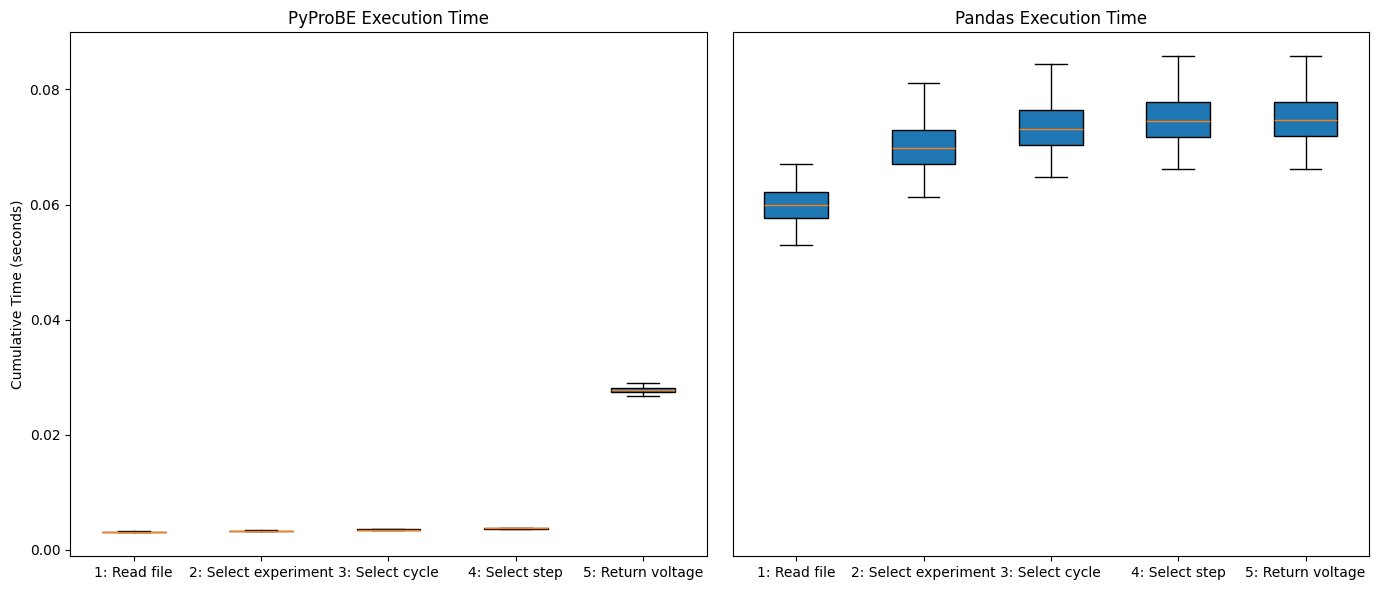

The median execution time for the filtering query in PyProBE is 2.68 times faster than Pandas.


In [4]:
repeats = 100
total_time_pyprobe, pyprobe_time, pyprobe_voltage  = measure_pyprobe(repeats, 'sample_data_neware.parquet')
total_time_pandas, csv_time_pandas, pandas_time, pandas_voltage = measure_pandas(repeats, 'sample_data_neware.parquet')
make_boxplots(total_time_pyprobe, total_time_pandas)

median_total_time_idx_pyprobe = np.argsort(total_time_pyprobe[-1,:])[total_time_pyprobe.shape[1] // 2]
median_total_time_idx_pandas = np.argsort(total_time_pandas[-1,:])[total_time_pandas.shape[1] // 2]

median_total_time_pyprobe = total_time_pyprobe[:, median_total_time_idx_pyprobe]
median_total_time_pandas = total_time_pandas[:, median_total_time_idx_pandas]

print(f"The median execution time for the filtering query in PyProBE is {median_total_time_pandas[-1]/median_total_time_pyprobe[-1]:.2f} times faster than Pandas.")

Confirm that the same data has been retrieved:

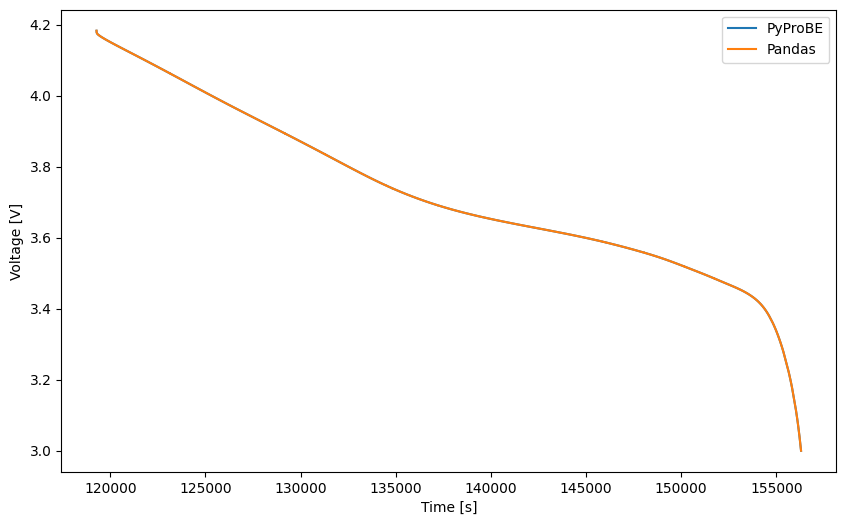

In [5]:
assert np.allclose(pyprobe_voltage, pandas_voltage)

plt.figure(figsize=(10, 6))
plt.plot(pyprobe_time, pyprobe_voltage, label='PyProBE')
plt.plot(pandas_time, pandas_voltage, label='Pandas')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()

Much of the performance behind PyProBE is careful selection of the data file format. PyProBE uses the .parquet file format due to its exceptional speed. The results above show pandas reading from the parquet format. The below plot illustrates its performance benefit:

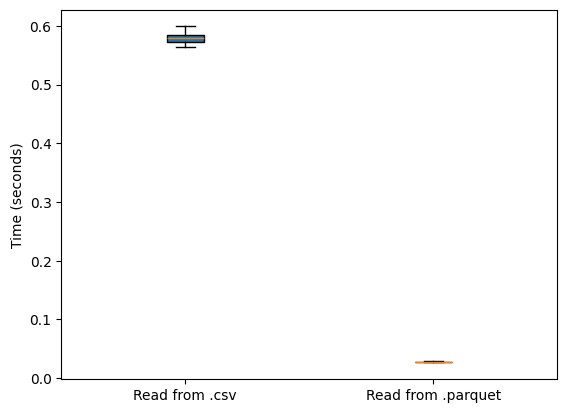

Reading from .parquet is on average 20.83 times faster than reading from .csv


In [6]:
plt.figure()
plt.boxplot([csv_time_pandas, total_time_pyprobe[-1,:]], tick_labels=['Read from .csv', 'Read from .parquet'], vert=True, patch_artist=True, showfliers=False)
plt.ylabel('Time (seconds)')
plt.show()

average_difference = np.median(csv_time_pandas)/np.median(total_time_pyprobe[-1,:])
print(f"Reading from .parquet is on average {average_difference:.2f} times faster than reading from .csv")

The sample dataset is not large, covering only around a week of testing. Battery degradation experiments can last for years, so the test below demonstrates the scalability of PyProBE to large data sets. We will now repeat our battery experiment multiple times and save the new dataset:

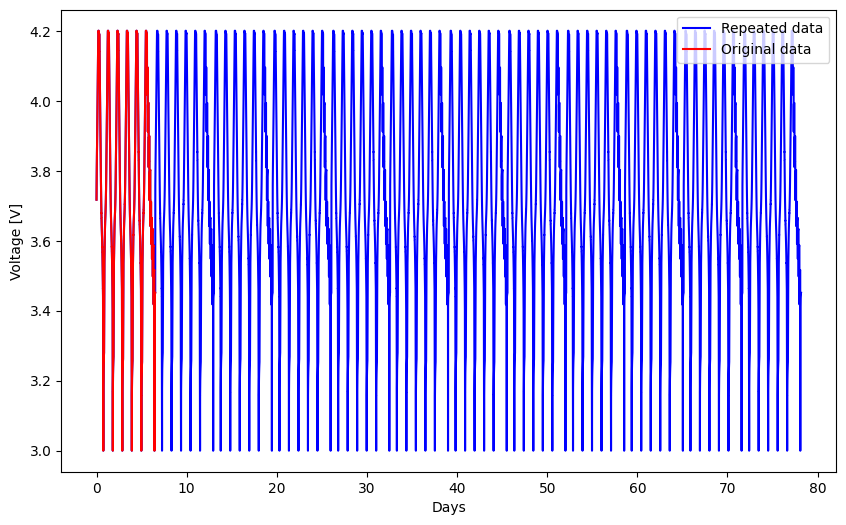

In [7]:
# Read the original data from the Parquet file
data = pl.read_parquet(data_directory + '/sample_data_neware.parquet')

# Repeat the data 
n_repeats = 12
repeated_data = pl.concat([data] * n_repeats)

# Repeat the 'Cycle' and 'Event' columns to match the length of the repeated data
cycle_repeated = pl.concat([data['Cycle']] * n_repeats)
event_repeated = pl.concat([data['Event']] * n_repeats)
step_repeated = pl.concat([data['Step']] * n_repeats)
time_repeated = pl.concat([data['Time [s]']]* n_repeats)

# Increment the 'Cycle' and 'Event' columns
cycle_increment = data['Cycle'].max() + 1
event_increment = data['Event'].max() + 1
step_increment = data['Step'].max() + 1
time_increment = data['Time [s]'].max()


repeated_data = repeated_data.with_columns([
    (pl.arange(0, len(repeated_data)) // len(data) * cycle_increment + cycle_repeated).alias('Cycle'),
    (pl.arange(0, len(repeated_data)) // len(data) * event_increment + event_repeated).alias('Event'),
    (pl.arange(0, len(repeated_data)) // len(data) * event_increment + step_repeated).alias('Step'),
    (pl.arange(0, len(repeated_data)) // len(data) * time_increment + time_repeated).alias('Time [s]'),
])

# Write the repeated data to a new Parquet file
repeated_data.write_parquet(data_directory + '/sample_data_neware_repeated.parquet')

# plot the repeated data
plt.figure(figsize=(10, 6))
plt.plot(repeated_data['Time [s]']/3600/24, repeated_data['Voltage [V]'], label='Repeated data', color='blue')
plt.plot(data['Time [s]']/3600/24, data['Voltage [V]'], label='Original data', color='red')
plt.xlabel('Days')
plt.ylabel('Voltage [V]')
plt.legend(loc = 'upper right')


And re-run the test:

The median execution time for the filtering query in PyProBE is 18.67 times faster than Pandas.
Execution time breakdown:
            Period   PyProBE    Pandas
0           1 week  0.027806  0.074652
1         12 weeks  0.034421  0.642664
2  Increase Factor  1.237909  8.608835


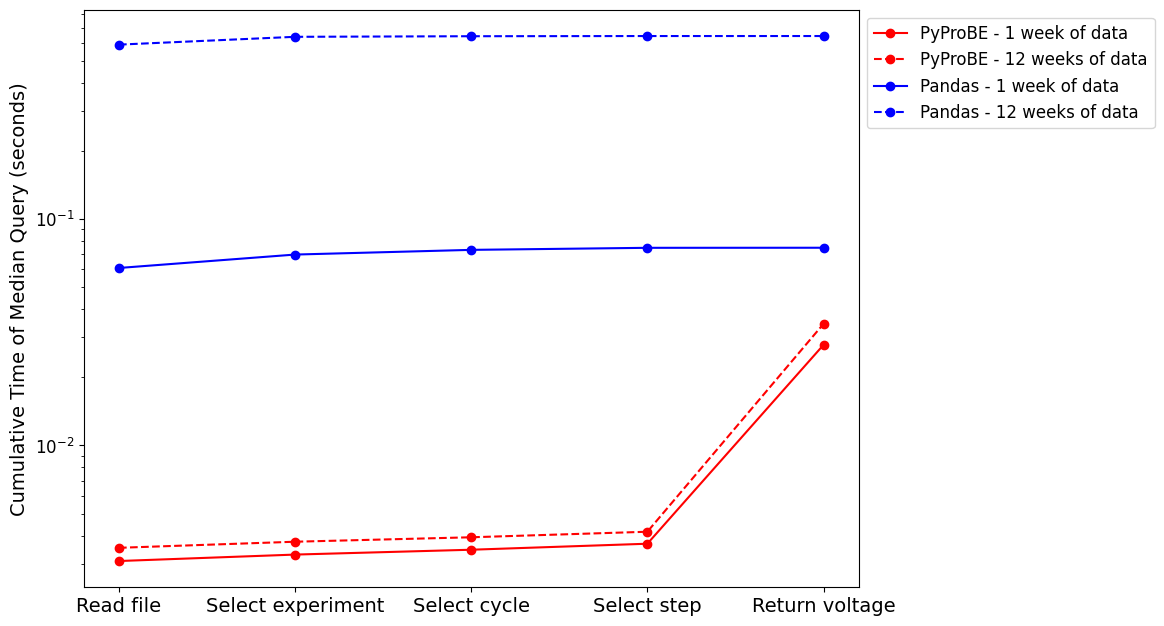

In [8]:
repeats = 100
rep_total_time_pyprobe, rep_pyprobe_time, rep_pyprobe_voltage = measure_pyprobe(repeats, 'sample_data_neware_repeated.parquet')
rep_total_time_pandas, rep_csv_time_pandas, rep_pandas_time, rep_pandas_voltage = measure_pandas(repeats, 'sample_data_neware_repeated.parquet', test_csv=False)

rep_median_total_time_idx_pyprobe = np.argsort(rep_total_time_pyprobe[-1,:])[rep_total_time_pyprobe.shape[1] // 2]
rep_median_total_time_idx_pandas = np.argsort(rep_total_time_pandas[-1,:])[rep_total_time_pandas.shape[1] // 2]

rep_median_total_time_pyprobe = rep_total_time_pyprobe[:, rep_median_total_time_idx_pyprobe]
rep_median_total_time_pandas = rep_total_time_pandas[:, rep_median_total_time_idx_pandas]

os.remove(data_directory + '/sample_data_neware_repeated.parquet')

print(f"The median execution time for the filtering query in PyProBE is {rep_median_total_time_pandas[-1]/rep_median_total_time_pyprobe[-1]:.2f} times faster than Pandas.")

plt.figure(figsize=(10, 7.5))
plt.plot(median_total_time_pyprobe, label='PyProBE - 1 week of data', marker='o', color='red')
plt.plot(rep_median_total_time_pyprobe, label=f'PyProBE - {n_repeats} weeks of data', marker='o', linestyle='--', color='red')
plt.plot(median_total_time_pandas, label='Pandas - 1 week of data', marker='o', color='blue')
plt.plot(rep_median_total_time_pandas, label=f'Pandas - {n_repeats} weeks of data', marker='o', linestyle='--', color='blue')
plt.yscale('log')
plt.xticks(range(5), ["Read file", "Select experiment", "Select cycle", "Select step", "Return voltage"], fontsize=14)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.ylabel('Cumulative Time of Median Query (seconds)', fontsize=14)

data = {
    'Period': ["1 week", f"{n_repeats} weeks", 'Increase Factor'],
    'PyProBE': [median_total_time_pyprobe[-1], rep_median_total_time_pyprobe[-1], rep_median_total_time_pyprobe[-1] / median_total_time_pyprobe[-1]],
    'Pandas': [median_total_time_pandas[-1], rep_median_total_time_pandas[-1], rep_median_total_time_pandas[-1] / median_total_time_pandas[-1]]}

print("Execution time breakdown:")
df = pd.DataFrame(data)
print(df)

Confirm that the same data has been retrieved:

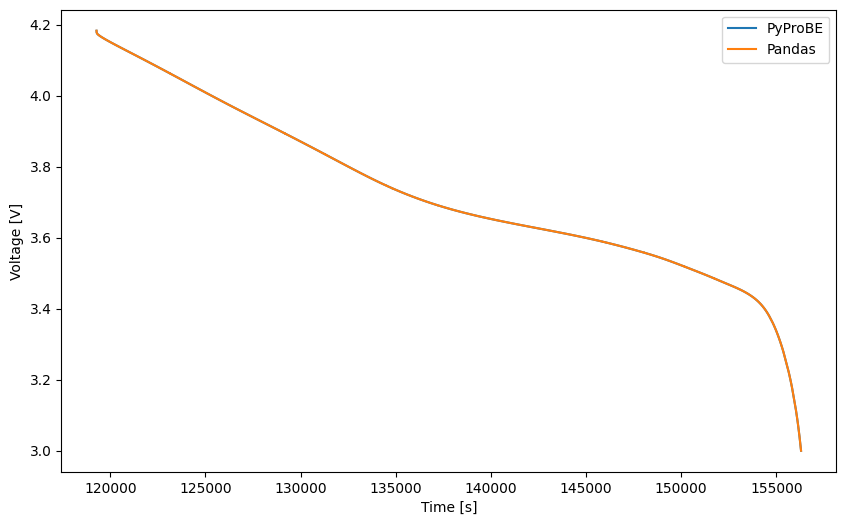

In [9]:
assert np.allclose(rep_pyprobe_voltage, rep_pandas_voltage)

plt.figure(figsize=(10, 6))
plt.plot(rep_pyprobe_time, rep_pyprobe_voltage, label='PyProBE')
plt.plot(rep_pandas_time, rep_pandas_voltage, label='Pandas')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()